In [ ]:
# Cicero tutorial (https://cole-trapnell-lab.github.io/cicero-release/docs/) is followed

In [96]:
#BiocManager::install("cicero")
library("cicero")

In [3]:
library("monocle")

In [17]:
#setwd("Desktop/cicero/")

# CICERO Tutorial 

In [4]:
temp <- textConnection(readLines(gzcon(url("http://staff.washington.edu/hpliner/data/kidney_data.txt.gz"))))


In [5]:
cicero_data <- read.table(temp)


In [19]:
dim(cicero_data)

[1] 35137     3

In [7]:
data(cicero_data)
head(cicero_data)

,Peak,Cell,Count
,<chr>,<chr>,<int>
140,chr18_30209631_30210783,AGCGATAGGCGCTATGGTGGAATTCAGTCAGGACGT,4
150,chr18_45820294_45821666,AGCGATAGGTAGCAGCTATGGTAATCCTAGGCGAAG,2
185,chr18_GL456216_random_32820116_32820994,TAATGCGCCGCTTATCGTTGGCAGCTCGGTACTGAC,2
266,chr18_41888433_41890138,AGCGATAGGCGCTATGGTGGAATTCAGTCAGGACGT,2
273,chr18_33038287_33039444,AGCGATAGGGTTATCGAACTCCATCGAGGTACTGAC,2
285,chr18_25533921_25534483,ATTACTCGAACGCGCAGAGGCGGAGGTCGTACTGAC,1


In [8]:
#The output of make_atac_cds is a valid CDS object ready to be input into downstream Cicero functions.

input_cds <- make_atac_cds(cicero_data, binarize = TRUE)

head(input_cds)

# Create a Cicero CDS

Because single-cell chromatin accessibility data is extremely sparse, accurate estimation of co-accessibility scores requires us to aggregate similar cells to create more dense count data. 
Cicero does this using a k-nearest-neighbors approach which creates overlapping sets of cells.

In [10]:
set.seed(2017)
input_cds <- detectGenes(input_cds)
input_cds <- estimateSizeFactors(input_cds)

In [11]:
input_cds <- reduceDimension(input_cds, max_components = 2, num_dim=6,
                      reduction_method = 'tSNE', norm_method = "none")

In [12]:
tsne_coords <- t(reducedDimA(input_cds))
row.names(tsne_coords) <- row.names(pData(input_cds))
cicero_cds <- make_cicero_cds(input_cds, reduced_coordinates = tsne_coords)

Overlap QC metrics:
Cells per bin: 50
Maximum shared cells bin-bin: 44
Mean shared cells bin-bin: 12.5047619047619
Median shared cells bin-bin: 1.5

Warning message in make_cicero_cds(input_cds, reduced_coordinates = tsne_coords):
"On average, more than 10% of cells are shared between paired bins."
Warning message in if (isSparseMatrix(counts)) {:
"the condition has length > 1 and only the first element will be used"


# Run Cicero

The easiest way to get Cicero co-accessibility scores is to run run_cicero. To run run_cicero, you need a cicero CDS object (created above) and a genome coordinates file, which contains the lengths of each of the chromosomes in your organism. 

#Second option: you can also call each function individually and set the parameter according to your dataset. 

In [18]:
data("human.hg19.genome")
sample_genome <- subset(human.hg19.genome, V1 == "chr18")
conns <- run_cicero(cicero_cds, sample_genome) # Takes a few minutes to run
head(conns)

[1] "Starting Cicero"
[1] "Calculating distance_parameter value"
[1] "Running models"
[1] "Assembling connections"
[1] "Successful cicero models:  283"
[1] "Other models: "

Zero or one element in range 
                          30 
[1] "Models with errors:  0"
[1] "Done"


,Peak1,Peak2,coaccess
,<chr>,<fct>,<dbl>
1,chr18_10006196_10006822,chr18_9755702_9755970,0.00000000
2,chr18_10006196_10006822,chr18_9756925_9757590,-0.02773593
3,chr18_10006196_10006822,chr18_9771216_9771842,-0.12618972
4,chr18_10006196_10006822,chr18_9781976_9782901,-0.07284726
5,chr18_10006196_10006822,chr18_9784605_9785105,0.00000000
6,chr18_10006196_10006822,chr18_9787597_9788029,0.00000000


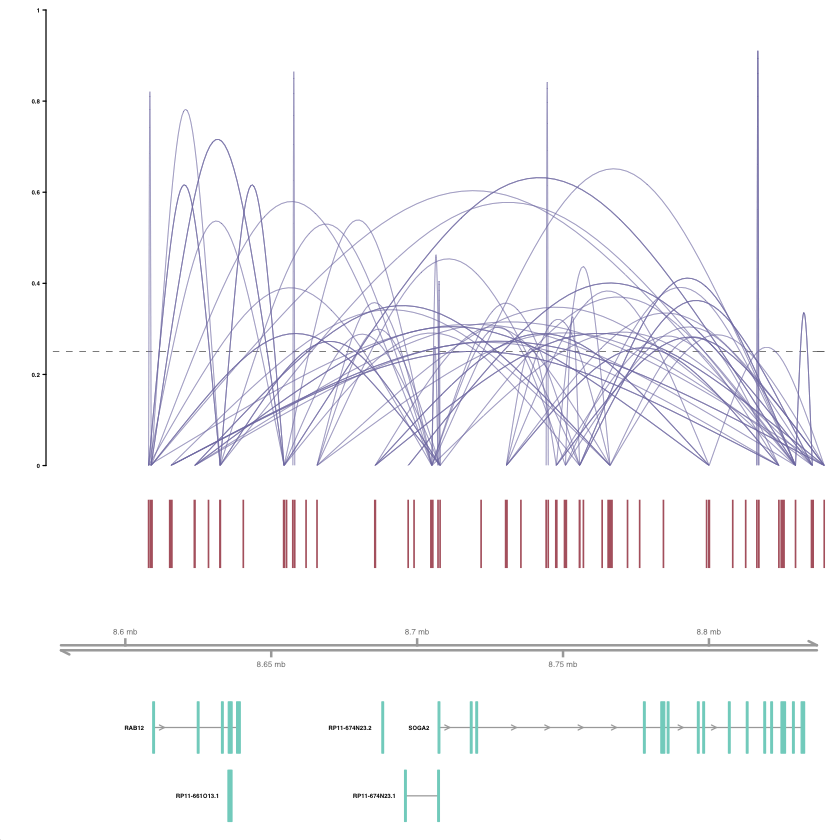

In [20]:
data(gene_annotation_sample)
plot_connections(conns, "chr18", 8575097, 8839855, 
                gene_model = gene_annotation_sample, 
                coaccess_cutoff = .25, 
                connection_width = .5, 
                collapseTranscripts = "longest" )


In [26]:
head(gene_annotation_sample)

,chromosome,start,end,strand,feature,gene,transcript,symbol
,<fct>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
411414,chr18,11103,11595,+,lincRNA,ENSG00000262352.1,ENST00000575820.1,AP005530.1
411415,chr18,15617,15822,+,lincRNA,ENSG00000262352.1,ENST00000575820.1,AP005530.1
411416,chr18,11191,11595,+,lincRNA,ENSG00000262352.1,ENST00000572573.1,AP005530.1
411417,chr18,13152,13354,+,lincRNA,ENSG00000262352.1,ENST00000572573.1,AP005530.1
411418,chr18,15617,15928,+,lincRNA,ENSG00000262352.1,ENST00000572573.1,AP005530.1
411419,chr18,45004,45235,+,pseudogene,ENSG00000262181.1,ENST00000575066.1,RP11-683L23.2


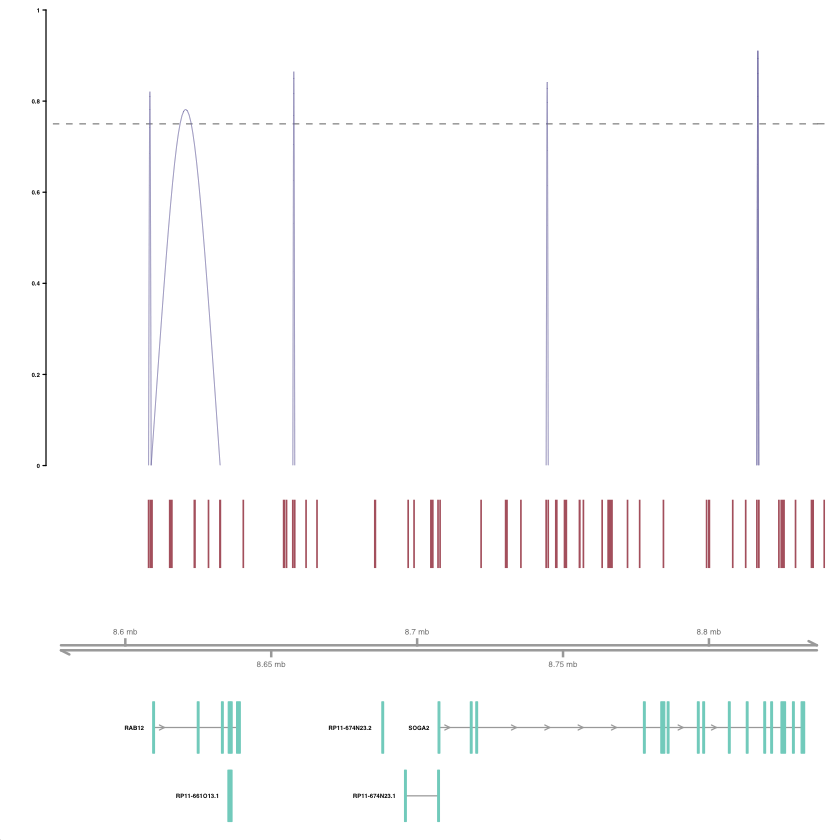

In [27]:
plot_connections(conns, "chr18", 8575097, 8839855, 
                gene_model = gene_annotation_sample, 
                coaccess_cutoff = .75, 
                connection_width = .5, 
                collapseTranscripts = "longest" )

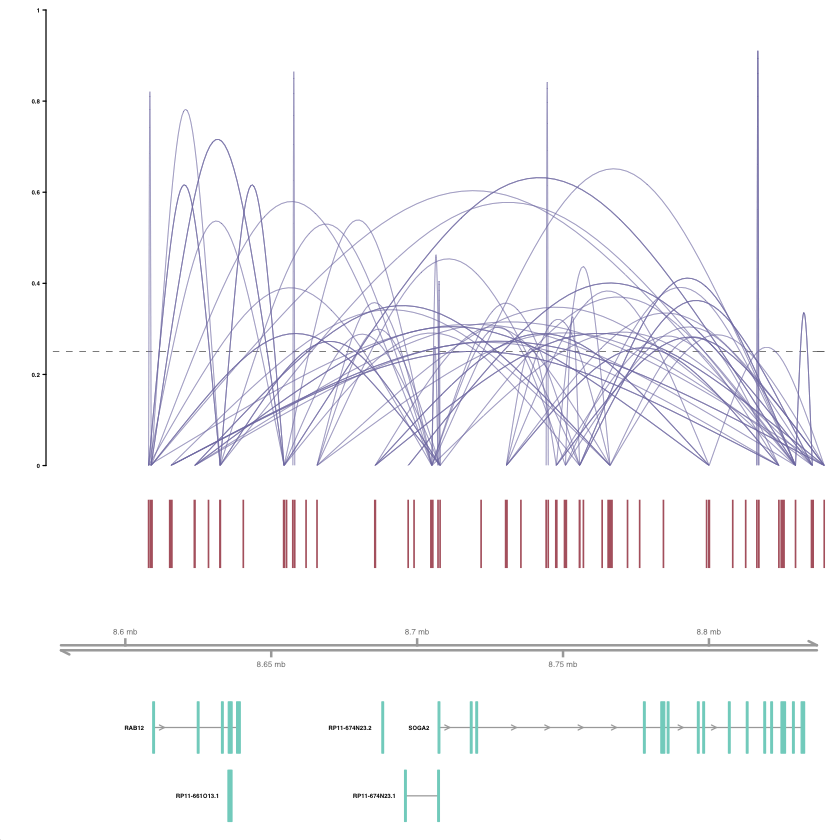

In [23]:
pp<-plot_connections(conns, "chr18", 8575097, 8839855, 
                gene_model = gene_annotation_sample, 
                coaccess_cutoff = .25, 
                connection_width = .5, 
                collapseTranscripts = "longest" )


# Finding cis-Co-accessibility Networks (CCANS)


Cicero also has a function to find Cis-Co-accessibility Networks (CCANs), which are modules of sites that are highly co-accessible with one another. We use the Louvain community detection algorithm (Blondel et al., 2008) to find clusters of sites that tended to be co-accessible.

In [28]:
CCAN_assigns <- generate_ccans(conns)

[1] "Coaccessibility cutoff used: 0.36"


In [95]:
head(CCAN_assigns)

,Peak,CCAN
,<chr>,<dbl>
chr18_10006196_10006822,chr18_10006196_10006822,1
chr18_10010479_10011360,chr18_10010479_10011360,1
chr18_10025_10225,chr18_10025_10225,3
chr18_10032281_10032988,chr18_10032281_10032988,1
chr18_10040565_10041732,chr18_10040565_10041732,1
chr18_10047081_10047763,chr18_10047081_10047763,1


# Add links to a Seurat object 

We can add the co-accessible links found by Cicero to the ChromatinAssay object in Seurat. Using the ConnectionsToLinks() function in Signac we can convert the outputs of Cicero to the format needed to store in the links slot in the ChromatinAssay, and add this to the object using the Links<- assignment function.

In [ ]:
#Bone: seurat object 

In [ ]:
library(Signac)

In [ ]:
links <- ConnectionsToLinks(conns = conns, ccans = ccans)
Links(bone) <- links

In [ ]:
#We can now visualize these links along with DNA accessibility information by running CoveragePlot() for a region:

CoveragePlot(bone, region = "chr1-40189344-40252549")


# Gene activity scores 

In [34]:
#### Add a column for the fData table indicating the gene if a peak is a promoter ####
# Create a gene annotation set that only marks the transcription start sites of 
# the genes. We use this as a proxy for promoters.
# To do this we need the first exon of each transcript
pos <- subset(gene_annotation_sample, strand == "+")
pos <- pos[order(pos$start),] 
pos <- pos[!duplicated(pos$transcript),] # remove all but the first exons per transcript
pos$end <- pos$start + 1 # make a 1 base pair marker of the TSS

neg <- subset(gene_annotation_sample, strand == "-")
neg <- neg[order(neg$start, decreasing = TRUE),] 
neg <- neg[!duplicated(neg$transcript),] # remove all but the first exons per transcript
neg$start <- neg$end - 1

gene_annotation_sub <- rbind(pos, neg)

In [35]:
# Make a subset of the TSS annotation columns containing just the coordinates 
# and the gene name
gene_annotation_sub <- gene_annotation_sub[,c(1:3, 8)]

# Rename the gene symbol column to "gene"
names(gene_annotation_sub)[4] <- "gene"

input_cds <- annotate_cds_by_site(input_cds, gene_annotation_sub)

head(fData(input_cds))


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr18_GL456216_random
  - in 'y': chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr19, chr20, chr21, chr22, chrX, chrY, chrM
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr18_GL456216_random
  - in 'y': chr1, chr2, chr3, chr4, chr5, chr6, chr7, chr8, chr9, chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr19, chr20, chr21, chr22, chrX, chrY, chrM
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."


,site_name,chr,bp1,bp2,num_cells_expressed,overlap,gene
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>
chr18_10025_10225,chr18_10025_10225,18,10025,10225,5,NA,NA
chr18_10603_11103,chr18_10603_11103,18,10603,11103,1,1,AP005530.1
chr18_11604_13986,chr18_11604_13986,18,11604,13986,9,NA,NA
chr18_49557_50057,chr18_49557_50057,18,49557,50057,2,1,RP11-683L23.1
chr18_50240_50740,chr18_50240_50740,18,50240,50740,2,1,RP11-683L23.1
chr18_104385_104585,chr18_104385_104585,18,104385,104585,1,NA,NA


In [45]:
str(fData(input_cds))

'data.frame':	6146 obs. of  7 variables:
 $ site_name          : chr  "chr18_10025_10225" "chr18_10603_11103" "chr18_11604_13986" "chr18_49557_50057" ...
 $ chr                : chr  "18" "18" "18" "18" ...
 $ bp1                : num  10025 10603 11604 49557 50240 ...
 $ bp2                : num  10225 11103 13986 50057 50740 ...
 $ num_cells_expressed: int  5 1 9 2 2 1 2 22 2 2 ...
 $ overlap            : int  NA 1 NA 1 1 NA 1 2 NA NA ...
 $ gene               : chr  NA "AP005530.1" NA "RP11-683L23.1" ...


In [53]:
#write.csv(df,"check_genename.csv")

In [38]:
#### Generate gene activity scores ####
# generate unnormalized gene activity matrix
unnorm_ga <- build_gene_activity_matrix(input_cds, conns)
head(unnorm_ga,2)

   [[ suppressing 200 column names 'AGCGATAGAACGAATTCGGCGCAATGACCCTATCCT', 'AGCGATAGAAGTACGCGATCCGCGGACTGTACTGAC', 'AGCGATAGAATACGATAAGGCCGTCAACTAATCTTA' ... ]]



2 x 200 sparse Matrix of class "dgCMatrix"
                                                                              
ABHD3      1 . 1.155707 . . . . . . . . . . 0.2460431 1.40175 1 1 1.246043 1 .
AC007631.1 . . .        . . . . . . . . . . .         .       . . .        . .
                                                                               
ABHD3      1 . 1 . . . 1.210499 . 1 . 1.153915 . . . . . . . . 1.389542 . . . .
AC007631.1 . . . . . . .        . . . .        . . . . . . . . .        . . . .
                                                                           
ABHD3      . . . . . . . . . . 1.155707 1 . . . . . . 0.2338359 . . . . . .
AC007631.1 . . . . . . . . . . .        . . . . . . . .         . . . . . .
                                                                               
ABHD3      1.210499 0.1539152 . . . . 1 . . . . . . . 0.2338359 . . . . 1 . . 1
AC007631.1 .        .         . . . . . . . . . . . . .         . . . . . . . .
            

In [41]:
# remove any rows/columns with all zeroes
unnorm_ga <- unnorm_ga[!Matrix::rowSums(unnorm_ga) == 0, !Matrix::colSums(unnorm_ga) == 0]

# make a list of num_genes_expressed
num_genes <- pData(input_cds)$num_genes_expressed
names(num_genes) <- row.names(pData(input_cds))

# normalize
cicero_gene_activities <- normalize_gene_activities(unnorm_ga, num_genes)
head(cicero_gene_activities,1:2)

1 x 2 sparse Matrix of class "dgCMatrix"
      AGCGATAGAACGAATTCGGCGCAATGACCCTATCCT AGCGATAGAAGTACGCGATCCGCGGACTGTACTGAC
ABHD3                           0.01023895                                    .

In [68]:
dd<-as.data.frame(as.matrix(cicero_gene_activities))
head(dd)
write.csv(dd, "cicero_gene_activities.csv") #if you know the cell type of these cell IDs, 
#then you can cluster them based on cell types and look at cell-type specific gene activities 

,AGCGATAGAACGAATTCGGCGCAATGACCCTATCCT,AGCGATAGAAGTACGCGATCCGCGGACTGTACTGAC,AGCGATAGAATACGATAAGGCCGTCAACTAATCTTA,AGCGATAGATTATGCAAGCCAGTACTTGCCTATCCT,AGCGATAGCAGACTAAGGGGAATTCAGTGGCTCTGA,AGCGATAGCCGTATGATTAGATCTTGGTCAGGACGT,AGCGATAGCGCGGCCATAGGTCTCGCCGCAGGACGT,AGCGATAGGATTCTTGAAAGGACGGACGAGGCGAAG,AGCGATAGGCGCTATGGTGGAATTCAGTCAGGACGT,AGCGATAGGGTTATCGAACTCCATCGAGGTACTGAC,⋯,TCTCGCGCAATATTACTTGGTCTCGCCGCAGGACGT,TCTCGCGCAGTTCTCATGCATATCCTATGTACTGAC,TCTCGCGCCAGCTAGCGGAGTCATAGCCTAATCTTA,TCTCGCGCCGCGGCCATAGTAATGATCGGGCTCTGA,TCTCGCGCCTACTAATAATGGTAATCCTTATAGCCT,TCTCGCGCCTCGTCGTAGGGCGGAGGTCGGCTCTGA,TCTCGCGCGCATATGAGCCTCTAACTCGCCTATCCT,TCTCGCGCGCGTTCCGTTTCGTTAGAGCTAATCTTA,TCTCGCGCTCGGATTCGGCGTTCTATCAGTACTGAC,TCTCGCGCTCTTGAGGTTTTATGACCAAATAGAGGC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ABHD3,0.01023895,0,0.01155254,0,0,0,0.00000000,0,0.000000000,0.000000000,⋯,0,0,0.000000000,0,0,0.02169365,0,0,0,0
AC007631.1,0.00000000,0,0.00000000,0,0,0,0.00000000,0,0.000000000,0.000000000,⋯,0,0,0.000000000,0,0,0.00000000,0,0,0,0
AC009802.1,0.00000000,0,0.00000000,0,0,0,0.00000000,0,0.000000000,0.000000000,⋯,0,0,0.000000000,0,0,0.00000000,0,0,0,0
AC011225.1,0.00000000,0,0.00000000,0,0,0,0.00000000,0,0.000000000,0.000000000,⋯,0,0,0.000000000,0,0,0.00000000,0,0,0,0
AC012123.1,0.00000000,0,0.00000000,0,0,0,0.00000000,0,0.000000000,0.000000000,⋯,0,0,0.000000000,0,0,0.00000000,0,0,0,0
AC015933.2,0.00000000,0,0.00000000,0,0,0,0.03402489,0,0.005447928,0.001470231,⋯,0,0,0.005677883,0,0,0.00000000,0,0,0,0


# Advancer visualization 

In [ ]:
# Pull out genomic location of a specific gene 

In [72]:
head(gene_annotation_sample)
head(gene_annotation_sub)


,chromosome,start,end,strand,feature,gene,transcript,symbol
,<fct>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
411414,chr18,11103,11595,+,lincRNA,ENSG00000262352.1,ENST00000575820.1,AP005530.1
411415,chr18,15617,15822,+,lincRNA,ENSG00000262352.1,ENST00000575820.1,AP005530.1
411416,chr18,11191,11595,+,lincRNA,ENSG00000262352.1,ENST00000572573.1,AP005530.1
411417,chr18,13152,13354,+,lincRNA,ENSG00000262352.1,ENST00000572573.1,AP005530.1
411418,chr18,15617,15928,+,lincRNA,ENSG00000262352.1,ENST00000572573.1,AP005530.1
411419,chr18,45004,45235,+,pseudogene,ENSG00000262181.1,ENST00000575066.1,RP11-683L23.2


,chromosome,start,end,gene
,<fct>,<dbl>,<dbl>,<chr>
411414,chr18,11103,11104,AP005530.1
411416,chr18,11191,11192,AP005530.1
411419,chr18,45004,45005,RP11-683L23.2
411421,chr18,112367,112368,ROCK1P1
411425,chr18,116842,116843,ROCK1P1
411428,chr18,158383,158384,USP14


In [78]:
df[order(-df$num_cells_expressed),]

,site_name,chr,bp1,bp2,num_cells_expressed,overlap,gene
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>
chr18_12946716_12948504,chr18_12946716_12948504,18,12946716,12948504,69,2,SEH1L
chr18_3623479_3625231,chr18_3623479_3625231,18,3623479,3625231,63,NA,NA
chr18_48722772_48724984,chr18_48722772_48724984,18,48722772,48724984,62,NA,NA
chr18_9135952_9138047,chr18_9135952_9138047,18,9135952,9138047,60,2,RP11-143J12.2
chr18_47338845_47340965,chr18_47338845_47340965,18,47338845,47340965,60,2,ACAA2
chr18_3261353_3262954,chr18_3261353_3262954,18,3261353,3262954,59,2,RP13-270P17.1
chr18_19320248_19321281,chr18_19320248_19321281,18,19320248,19321281,58,1,MIB1
chr18_29671318_29673733,chr18_29671318_29673733,18,29671318,29673733,57,2,RNF138
chr18_61033510_61035401,chr18_61033510_61035401,18,61033510,61035401,57,2,KDSR


In [79]:
df<- fData(input_cds)
df[grep("SMAD4", df$gene), ]

,site_name,chr,bp1,bp2,num_cells_expressed,overlap,gene
,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>
chr18_48555484_48556967,chr18_48555484_48556967,18,48555484,48556967,56,2,SMAD4
chr18_48576963_48577463,chr18_48576963_48577463,18,48576963,48577463,3,1,SMAD4
chr18_48592692_48593192,chr18_48592692_48593192,18,48592692,48593192,2,1,SMAD4
chr18_48602590_48603621,chr18_48602590_48603621,18,48602590,48603621,10,1,SMAD4


In [94]:
head(gene_annotation_sample[grep("SMAD4", gene_annotation_sample$symbol),])

,chromosome,start,end,strand,feature,gene,transcript,symbol
,<fct>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
416547,chr18,48494410,48494484,+,protein_coding,ENSG00000141646.9,ENST00000452201.2,SMAD4
416548,chr18,48500767,48500931,+,protein_coding,ENSG00000141646.9,ENST00000452201.2,SMAD4
416549,chr18,48573290,48573665,+,protein_coding,ENSG00000141646.9,ENST00000452201.2,SMAD4
416550,chr18,48575056,48575230,+,protein_coding,ENSG00000141646.9,ENST00000452201.2,SMAD4
416551,chr18,48575665,48575694,+,protein_coding,ENSG00000141646.9,ENST00000452201.2,SMAD4
416552,chr18,48577724,48577785,+,protein_coding,ENSG00000141646.9,ENST00000452201.2,SMAD4


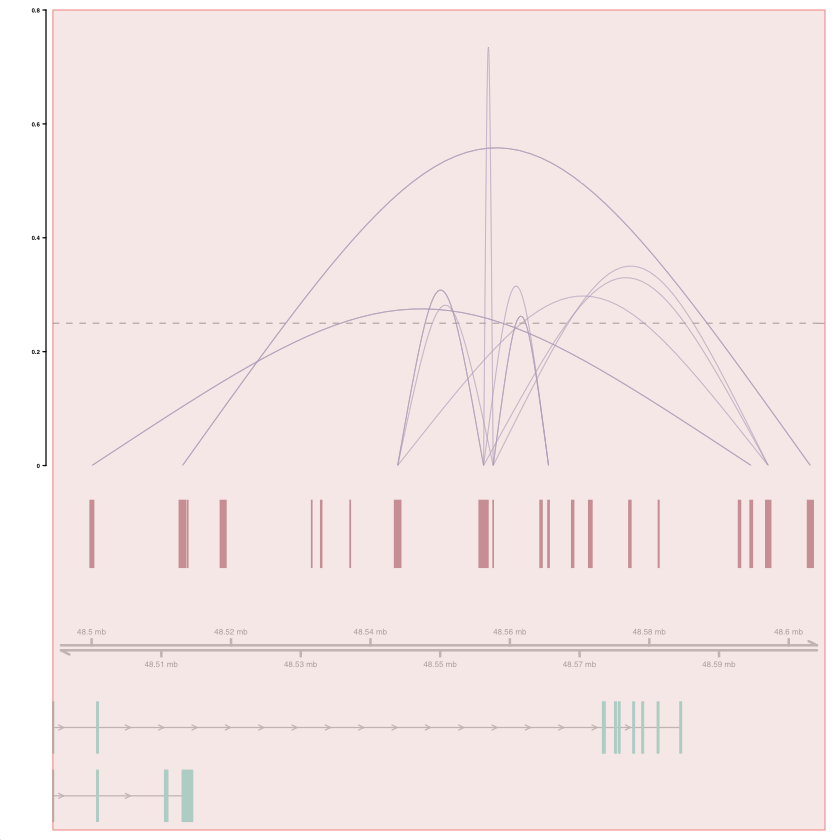

In [88]:
plot_connections(conns, "chr18", 48494410, 48605240, 
                viewpoint = "chr18_48494410_48605240",
                gene_model = gene_annotation_sample, 
                coaccess_cutoff = 0.25,
                connection_width = .5,
                #comparison_track = chia_conns,
                #include_axis_track = F,
                collapseTranscripts = "longest") 

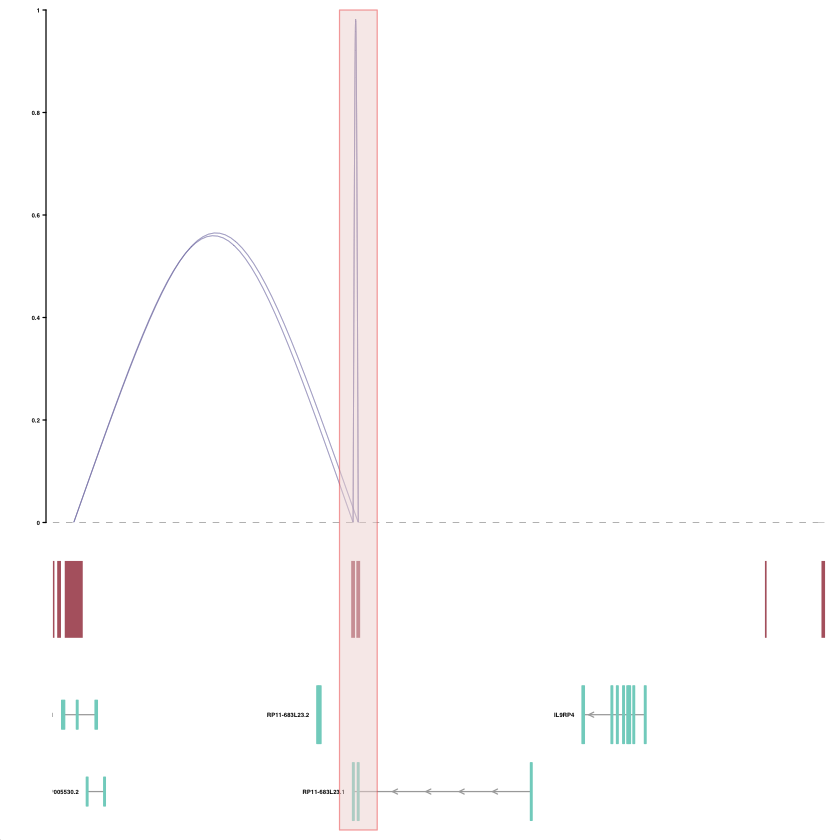

In [90]:
plot_connections(conns, "chr18", 10000, 112367, 
                viewpoint = "chr18_48000_53000",
                gene_model = gene_annotation_sample, 
                coaccess_cutoff = 0,
                connection_width = .5,
                #comparison_track = chia_conns,
                include_axis_track = F,
                collapseTranscripts = "longest") 